In [2]:
#Author: Hans Mohrmann

import xarray as xr
import numpy as np
import pandas as pd
import pickle
import os
from joblib import dump, load
import datetime
import matplotlib.pyplot as plt
import glob
from phase_psd import *
%load_ext autoreload
%autoreload 2
print('BOGIES')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
BOGIES


In [3]:
def add_datetime_to_processed_data(proc_data):
    """take the 2DS processed dataset and reindex the time properly"""
    secs = (proc_data.Time.values%100) + proc_data.msec.values/1000
    mins = (proc_data.Time.values//100)%100
    hours = proc_data.Time.values//10000
    
    day = proc_data.Date.values%100
    months = (proc_data.Date.values//100)%100
    year = proc_data.Date.values//10000
    datetime = np.array(
        [np.datetime64(f'{int(year[i])}-{int(months[i]):02}-{int(day[i]):02}T{int(hours[i]):02}:{int(mins[i]):02}:{int(secs[i]):06.3f}') for i in range(len(year))])
    proc_data['datetime'] = (['time'], datetime)
    return proc_data
def bootstrap_ml_classifications(cats, certs, n_iters=1):
    """generate multiple realizations of an array of binary classifications based on the classification certainty
    
    Inputs:
        cats: nx1 array of binary classifications (0 or 1) [numpy.array]
        certs: nx1 array of classification probability or model certainty (range 0-1) [numpy.array]
        n_iters: number of desired realizations [int]
    Outputs:
        realizations: nxn_iters array of different possible realizations [numpy.array]
    """
    flipped_certs = certs.copy()
    flipped_certs[~cats.astype(bool)] = 1 - flipped_certs[~cats.astype(bool)]
    flipped_certs = np.tile(flipped_certs, (n_iters,1)).squeeze()
    
    realizations = (np.random.rand(*flipped_certs.shape) < flipped_certs).astype(int)
    return realizations
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

In [38]:
  flt_string = 'rf12'
  navfilename = glob.glob('/home/disk/eos9/jfinlon/socrates/' + flt_string + '/*.PNI.nc')[0]
  pbpfilename = '/home/disk/eos9/jfinlon/socrates/' + flt_string + '/pbp.' + flt_string + '.2DS.H.nc'
  phasefilename = '/home/disk/eos9/jkcm/Data/particle/classified/' + 'UW_particle_classifications.' + flt_string + '.nc'
  [flt_time, flt_tas] = load_nav(navfilename)
  [time, diam_minR, diam_areaR, phase_ml, phase_holroyd, phase_ar,
   prob_ml, time_all, intArr, ovrld_flag] = load_pbp(
      pbpfilename, phasefilename, Dmin=0.05, Dmax=3.2, iatThresh=1.e-6)

Loading the particle data. This may take a minute...
Loading the phase ID data.
Removing the rejected particles.


In [23]:
psd = make_psd(flt_time, flt_tas, time, diam_minR, diam_areaR, phase_ml, prob_ml, phase_holroyd, phase_ar,
      time_all, intArr, ovrld_flag, bootstrap=True, binEdges=None, tres=1)

bootstrapping with 30 samples...
Processing 1000 of 12193 (2018-01-16T00:35:55)
Processing 2000 of 12193 (2018-01-16T00:54:41)
Processing 3000 of 12193 (2018-01-16T01:14:56)
Processing 4000 of 12193 (2018-01-16T01:46:34)
Processing 5000 of 12193 (2018-01-16T02:31:08)
Processing 6000 of 12193 (2018-01-16T02:49:35)
Processing 7000 of 12193 (2018-01-16T03:06:15)
Processing 8000 of 12193 (2018-01-16T03:34:46)
Processing 9000 of 12193 (2018-01-16T04:20:45)
Processing 10000 of 12193 (2018-01-16T04:47:33)
Processing 11000 of 12193 (2018-01-16T05:16:56)
Processing 12000 of 12193 (2018-01-16T05:46:47)
bootstrapping summary stats...
:count_dmax_liq_ml shape: (26091, 27)
HELLO!
(26091, 27)
(26091, 27, 1)
(1, 27, 1)

Elapsed time: 62.125818 seconds


In [24]:
psd_nobs = make_psd(flt_time, flt_tas, time, diam_minR, diam_areaR, phase_ml, prob_ml, phase_holroyd, phase_ar,
      time_all, intArr, ovrld_flag, bootstrap=False, binEdges=None, tres=1)

Processing 1000 of 12193 (2018-01-16T00:35:55)
Processing 2000 of 12193 (2018-01-16T00:54:41)
Processing 3000 of 12193 (2018-01-16T01:14:56)
Processing 4000 of 12193 (2018-01-16T01:46:34)
Processing 5000 of 12193 (2018-01-16T02:31:08)
Processing 6000 of 12193 (2018-01-16T02:49:35)
Processing 7000 of 12193 (2018-01-16T03:06:15)
Processing 8000 of 12193 (2018-01-16T03:34:46)
Processing 9000 of 12193 (2018-01-16T04:20:45)
Processing 10000 of 12193 (2018-01-16T04:47:33)
Processing 11000 of 12193 (2018-01-16T05:16:56)
Processing 12000 of 12193 (2018-01-16T05:46:47)
:count_dmax_liq_ml shape: (26091, 27)

Elapsed time: 44.075739 seconds


In [48]:
all_flights = [f'rf{i:02}' for i in np.arange(1,16)]
for flt_string in all_flights:
    try:
        outfile = f'/home/disk/eos9/jkcm/Data/particle/psd/{flt_string}_psd.nc'
        navfilename = glob.glob('/home/disk/eos9/jfinlon/socrates/' + flt_string + '/*.PNI.nc')[0]
        pbpfilename = '/home/disk/eos9/jfinlon/socrates/' + flt_string + '/pbp.' + flt_string + '.2DS.H.nc'
        phasefilename = '/home/disk/eos9/jkcm/Data/particle/classified/' + 'UW_particle_classifications.' + flt_string + '.nc'
        [flt_time, flt_tas] = load_nav(navfilename)
        [time, diam_minR, diam_areaR, phase_ml, phase_holroyd, phase_ar, prob_ml, time_all, intArr, ovrld_flag] = load_pbp(
            pbpfilename, phasefilename, Dmin=0.05, Dmax=3.2, iatThresh=1.e-6)

        psd = make_psd(flt_time, flt_tas, time, diam_minR, diam_areaR, phase_ml, prob_ml, phase_holroyd, phase_ar,
          time_all, intArr, ovrld_flag, bootstrap=True, binEdges=None, tres=1, outfile=outfile)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        print(f'error on flight {flt_string}:')
        print(e)
        continue
        

Loading the particle data. This may take a minute...
Loading the phase ID data.
Removing the rejected particles.
bootstrapping with 30 samples...
Processing 1000 of 12193 (2018-01-16T00:35:55)
Processing 2000 of 12193 (2018-01-16T00:54:41)
Processing 3000 of 12193 (2018-01-16T01:14:56)
Processing 4000 of 12193 (2018-01-16T01:46:34)
Processing 5000 of 12193 (2018-01-16T02:31:08)
Processing 6000 of 12193 (2018-01-16T02:49:35)
Processing 7000 of 12193 (2018-01-16T03:06:15)
Processing 8000 of 12193 (2018-01-16T03:34:46)
Processing 9000 of 12193 (2018-01-16T04:20:45)
Processing 10000 of 12193 (2018-01-16T04:47:33)
Processing 11000 of 12193 (2018-01-16T05:16:56)
Processing 12000 of 12193 (2018-01-16T05:46:47)
bootstrapping summary stats...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-dd7214c63c49>", line 15, in <module>
    raise e
  File "<ipython-input-48-dd7214c63c49>", line 13, in <module>
    time_all, intArr, ovrld_flag, bootstrap=True, binEdges=None, tres=1, outfile=outfile)
  File "/home/disk/p/jkcm/Code/UW-particle-phase-classifier/python_scripts/phase_psd.py", line 395, in make_psd
    count_dmax_liq_ml_25pct = np.nanpercentile(count_dmax_liq_ml_bs, q=25, axis=-1)
  File "/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/numpy/lib/nanfunctions.py", line 1209, in nanpercentile
    a, q, axis, out, overwrite_input, interpolation, keepdims)
  File "/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/numpy/lib/nanfunctions.py", line 1334, in _nanquantile_

KeyboardInterrupt: 

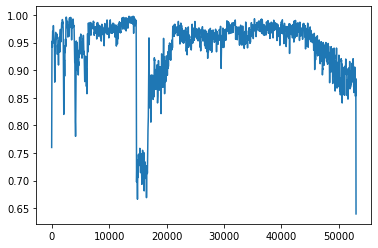

In [31]:
probs = smooth(prob_ml, window_len=100)
plt.plot(probs)

In [8]:
[print(i) for i in psd.keys()];

time
bin_edges
bin_width
deadtime_flag
count_dmax_all
count_dmax_liq_ml
count_dmax_ice_ml
count_dmax_liq_holroyd
count_dmax_ice_holroyd
count_dmax_liq_ar
count_dmax_ice_ar
count_darea_all
count_darea_liq_ml
count_darea_ice_ml
count_darea_liq_holroyd
count_darea_ice_holroyd
count_darea_liq_ar
count_darea_ice_ar
sample_volume
lwc_ml
lwc_holroyd
lwc_ar
count_dmax_liq_ml_mean
count_dmax_ice_ml_mean
count_darea_liq_ml_mean
count_darea_ice_ml_mean
count_dmax_liq_ml_median
count_dmax_ice_ml_median
count_darea_liq_ml_median
count_darea_ice_ml_median
count_dmax_liq_ml_min
count_dmax_ice_ml_min
count_darea_liq_ml_min
count_darea_ice_ml_min
count_dmax_liq_ml_max
count_dmax_ice_ml_max
count_darea_liq_ml_max
count_darea_ice_ml_max
count_dmax_liq_ml_stddev
count_dmax_ice_ml_stddev
count_darea_liq_ml_stddev
count_darea_ice_ml_stddev
lwc_ml_all
lwc_ml_mean
lwc_ml_median
lwc_ml_min
lwc_ml_max
lwc_ml_stddev
lwc_ml_25pct
lwc_ml_75pct


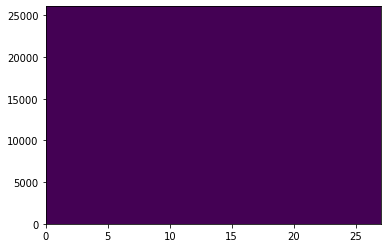

In [37]:
plt.pcolormesh(psd['count_darea_ice_ml']-psd_nobs['count_darea_ice_ml'], vmax=10)

In [ ]:
plt.pcolormesh(psd['count_darea_ice_ml'], vmax=10)

In [12]:
mask = np.logical_and(psd['time']>time[15000], psd['time']<time[16000])

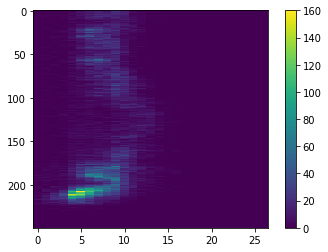

In [25]:
plt.imshow(psd['count_darea_ice_ml_min'][20000:20250,], aspect = 1e-1)
plt.colorbar()

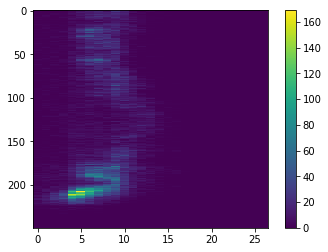

In [33]:
plt.imshow(psd['count_darea_ice_ml'][20000:20250,], aspect = 1e-1)
plt.colorbar()

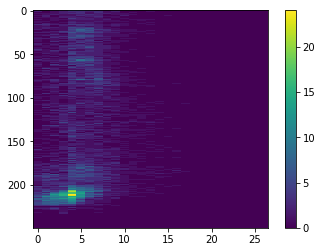

In [35]:
minmax = psd['count_darea_ice_ml_max']-psd['count_darea_ice_ml_min']
plt.imshow(minmax[20000:20250,], aspect = 1e-1)
plt.colorbar()

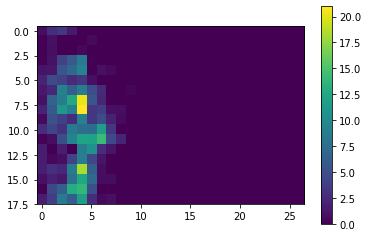

In [37]:
plt.imshow(psd['count_darea_liq_ml'][mask], aspect = 1)
plt.colorbar()

In [63]:
[i for i in psd.keys()]

['time',
 'bin_edges',
 'bin_width',
 'deadtime_flag',
 'count_dmax_all',
 'count_dmax_liq_ml',
 'count_dmax_ice_ml',
 'count_dmax_liq_holroyd',
 'count_dmax_ice_holroyd',
 'count_dmax_liq_ar',
 'count_dmax_ice_ar',
 'count_darea_all',
 'count_darea_liq_ml',
 'count_darea_ice_ml',
 'count_darea_liq_holroyd',
 'count_darea_ice_holroyd',
 'count_darea_liq_ar',
 'count_darea_ice_ar',
 'sample_volume',
 'lwc_ml',
 'lwc_holroyd',
 'lwc_ar',
 'count_dmax_liq_ml_median',
 'count_dmax_ice_ml_median',
 'count_darea_liq_ml_median',
 'count_darea_ice_ml_median',
 'count_dmax_liq_ml_min',
 'count_dmax_ice_ml_min',
 'count_darea_liq_ml_min',
 'count_darea_ice_ml_min',
 'count_dmax_liq_ml_max',
 'count_dmax_ice_ml_max',
 'count_darea_liq_ml_max',
 'count_darea_ice_ml_max',
 'count_dmax_liq_ml_stddev',
 'count_dmax_ice_ml_stddev',
 'count_darea_liq_ml_stddev',
 'count_darea_ice_ml_stddev',
 'lwc_ml_all',
 'lwc_ml_median',
 'lwc_ml_min',
 'lwc_ml_max',
 'lwc_ml_stddev']

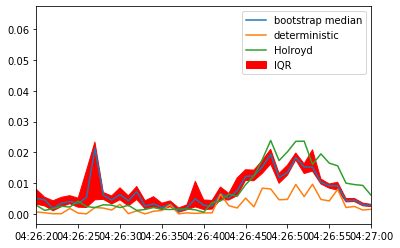

In [146]:
fig, ax = plt.subplots()
ax.plot(psd['time'], psd['lwc_ml_median'], label='bootstrap median')
ax.plot(psd_nobs['time'], psd_nobs['lwc_ml'], label='deterministic')
ax.plot(psd_nobs['time'], psd_nobs['lwc_holroyd'], label='Holroyd')


ax.fill_between(x=psd['time'], y1=psd['lwc_ml_25pct'], y2=psd['lwc_ml_75pct'], color='r', label='IQR')

ax.set_xlim([psd['time'][20180], psd['time'][20220]])
ax.legend()
mask = np.logical_and(psd['time']>psd['time'][20180], psd['time']<psd['time'][20220])

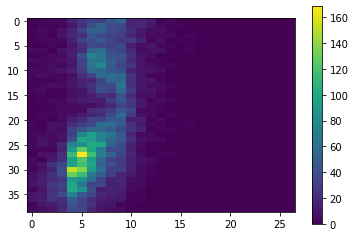

In [147]:
plt.imshow(psd['count_darea_ice_ml'][mask], aspect = 0.5)
plt.colorbar()

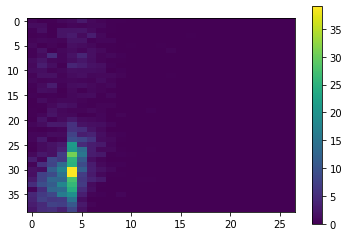

In [148]:
plt.imshow(psd['count_darea_liq_ml'][mask], aspect = 0.5)
plt.colorbar()

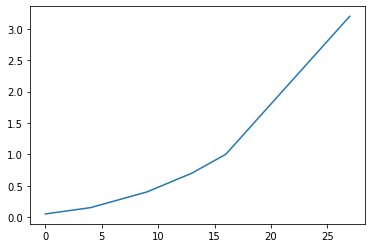

In [151]:
plt.plot(psd['bin_edges'])

In [139]:
psd['count_darea_ice_ml'].shape

(26091, 27)

In [152]:
prob_ml_2 = prob_ml.copy()
prob_ml_2[phase_ml==0] = -prob_ml_2[phase_ml==0]

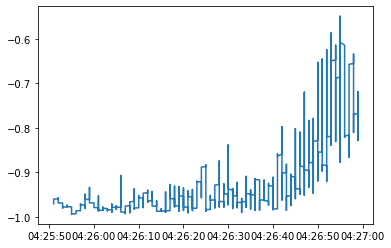

In [153]:
mask1 = np.logical_and(time>psd['time'][20150], time<psd['time'][20220])
plt.plot(time[mask1], smooth(prob_ml_2, window_len=101)[mask1])

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  """Entry point for launching an IPython kernel.


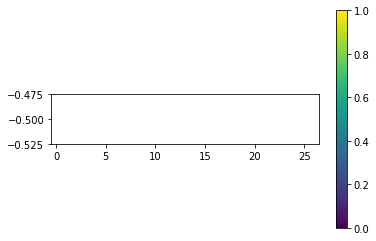

In [110]:
plt.imshow(psd['count_darea_liq_ml'][mask], aspect = 100)
plt.colorbar()

In [111]:
psd['count_darea_liq_ml'][mask].shape

(0, 27)

In [ ]:
fig, ax = plt.subplots()
ax.plot(psd['time'], psd['lwc_ml_median'], label='bootstrap median')

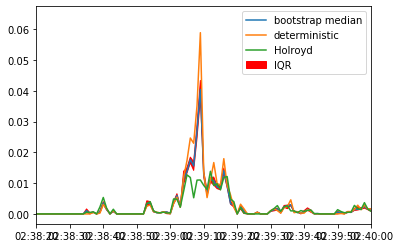

In [132]:
fig, ax = plt.subplots()
ax.plot(psd['time'], psd['lwc_ml_median'], label='bootstrap median')
ax.plot(psd_nobs['time'], psd_nobs['lwc_ml'], label='deterministic')
ax.plot(psd_nobs['time'], psd_nobs['lwc_holroyd'], label='Holroyd')


ax.fill_between(x=psd['time'], y1=psd['lwc_ml_25pct'], y2=psd['lwc_ml_75pct'], color='r', label='IQR')

ax.set_xlim([psd['time'][13700], psd['time'][13800]])
ax.legend()
mask = np.logical_and(psd['time']>time[13700], psd['time']<time[13800])

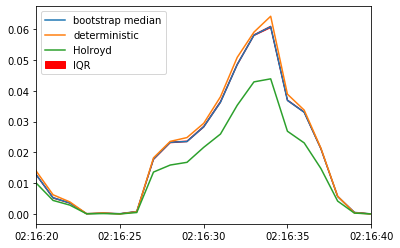

In [130]:
fig, ax = plt.subplots()
ax.plot(psd['time'], psd['lwc_ml_median'], label='bootstrap median')
ax.plot(psd_nobs['time'], psd_nobs['lwc_ml'], label='deterministic')
ax.plot(psd_nobs['time'], psd_nobs['lwc_holroyd'], label='Holroyd')


ax.fill_between(x=psd['time'], y1=psd['lwc_ml_25pct'], y2=psd['lwc_ml_75pct'], color='r', label='IQR')

ax.set_xlim([psd['time'][12380], psd['time'][12400]])
ax.legend()
mask = np.logical_and(psd['time']>time[13700], psd['time']<time[13800])

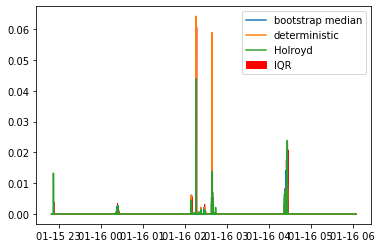

In [131]:
fig, ax = plt.subplots()
ax.plot(psd['time'], psd['lwc_ml_median'], label='bootstrap median')
ax.plot(psd_nobs['time'], psd_nobs['lwc_ml'], label='deterministic')
ax.plot(psd_nobs['time'], psd_nobs['lwc_holroyd'], label='Holroyd')
ax.fill_between(x=psd['time'], y1=psd['lwc_ml_25pct'], y2=psd['lwc_ml_75pct'], color='r', label='IQR')
ax.legend()


In [49]:
all_flights = [f'rf{i:02}' for i in np.arange(1,16)]
for flt_string in all_flights:
    outfile = f'/home/disk/eos9/jkcm/Data/particle/psd/{flt_string}_psd.nc'
    ds = xr.open_dataset(outfile)

In [54]:
ds = xr.open_mfdataset(glob.glob('/home/disk/eos9/jkcm/Data/particle/psd/rf*_psd.nc'), combine='by_coords')

In [172]:
# bins = (ds.bin_edges.values[1:]+ds.bin_edges.values[:-1])/2
bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]

ice_ml_hist = (ds.count_darea_ice_ml/ds.sample_volume).mean(dim='time').values
liq_ml_hist = (ds.count_darea_liq_ml/ds.sample_volume).mean(dim='time').values
ice_ar_hist = (ds.count_darea_ice_ar/ds.sample_volume).mean(dim='time').values
liq_ar_hist = (ds.count_darea_liq_ar/ds.sample_volume).mean(dim='time').values
ice_ho_hist = (ds.count_darea_ice_holroyd/ds.sample_volume).mean(dim='time').values
liq_ho_hist = (ds.count_darea_liq_holroyd/ds.sample_volume).mean(dim='time').values
ice_ml_hist_ml = (ds.count_darea_ice_ml_median/ds.sample_volume).mean(dim='time').values
liq_ml_hist_ml = (ds.count_darea_liq_ml_median/ds.sample_volume).mean(dim='time').values
ice_ml_hist_25 = (ds.count_darea_ice_ml_25pct/ds.sample_volume).mean(dim='time').values
liq_ml_hist_25 = (ds.count_darea_liq_ml_25pct/ds.sample_volume).mean(dim='time').values
ice_ml_hist_75 = (ds.count_darea_ice_ml_75pct/ds.sample_volume).mean(dim='time').values
liq_ml_hist_75 = (ds.count_darea_liq_ml_75pct/ds.sample_volume).mean(dim='time').values

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func

In [177]:
ds.sample_volume

<xarray.DataArray 'sample_volume' (time: 401715, size_bin: 27)>
dask.array<concatenate, shape=(401715, 27), dtype=float64, chunksize=(30301, 27), chunktype=numpy.ndarray>
Coordinates:
    bin_width  (size_bin) float64 dask.array<chunksize=(27,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2018-01-15T22:50:00 ... 2018-02-24T08:41:00
Dimensions without coordinates: size_bin
Attributes:
    units:    cm**3

In [195]:
# bins = (ds.bin_edges.values[1:]+ds.bin_edges.values[:-1])/2
bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]

sv = ds.sample_volume.sum(dim='time').values
sv = 1
ice_ml_hist = ds.count_darea_ice_ml.sum(dim='time').values/sv
liq_ml_hist = ds.count_darea_liq_ml.sum(dim='time').values/sv
ice_ar_hist = ds.count_darea_ice_ar.sum(dim='time').values/sv
liq_ar_hist = ds.count_darea_liq_ar.sum(dim='time').values/sv
ice_ho_hist = ds.count_darea_ice_holroyd.sum(dim='time').values/sv
liq_ho_hist = ds.count_darea_liq_holroyd.sum(dim='time').values/sv
ice_ml_hist_ml = ds.count_darea_ice_ml_median.sum(dim='time').values/sv
liq_ml_hist_ml = ds.count_darea_liq_ml_median.sum(dim='time').values/sv
ice_ml_hist_25 = ds.count_darea_ice_ml_25pct.sum(dim='time').values/sv
liq_ml_hist_25 = ds.count_darea_liq_ml_25pct.sum(dim='time').values/sv
ice_ml_hist_75 = ds.count_darea_ice_ml_75pct.sum(dim='time').values/sv
liq_ml_hist_75 = ds.count_darea_liq_ml_75pct.sum(dim='time').values/sv

In [174]:
# bins = (ds.bin_edges.values[1:]+ds.bin_edges.values[:-1])/2
bins = np.exp((np.log(ds.bin_edges.values)[1:]+np.log(ds.bin_edges.values)[:-1])/2)
log_width = np.log(ds.bin_edges.values)[1:]-np.log(ds.bin_edges.values)[:-1]

ice_ml_hist = ds.count_darea_ice_ml.mean(dim='time').values
liq_ml_hist = ds.count_darea_liq_ml.mean(dim='time').values
ice_ar_hist = ds.count_darea_ice_ar.mean(dim='time').values
liq_ar_hist = ds.count_darea_liq_ar.mean(dim='time').values
ice_ho_hist = ds.count_darea_ice_holroyd.mean(dim='time').values
liq_ho_hist = ds.count_darea_liq_holroyd.mean(dim='time').values
ice_ml_hist_ml = ds.count_darea_ice_ml_median.mean(dim='time').values
liq_ml_hist_ml = ds.count_darea_liq_ml_median.mean(dim='time').values
ice_ml_hist_25 = ds.count_darea_ice_ml_25pct.mean(dim='time').values
liq_ml_hist_25 = ds.count_darea_liq_ml_25pct.mean(dim='time').values
ice_ml_hist_75 = ds.count_darea_ice_ml_75pct.mean(dim='time').values
liq_ml_hist_75 = ds.count_darea_liq_ml_75pct.mean(dim='time').values

In [191]:
np.logspace(np.log10(56.4),np.log10(3200))/1000


array([0.0564    , 0.06124525, 0.06650674, 0.07222024, 0.07842459,
       0.08516193, 0.09247808, 0.10042274, 0.10904992, 0.11841825,
       0.1285914 , 0.13963851, 0.15163467, 0.16466139, 0.17880723,
       0.19416831, 0.21084904, 0.22896279, 0.24863267, 0.26999237,
       0.29318704, 0.31837433, 0.34572544, 0.37542623, 0.40767859,
       0.44270169, 0.48073359, 0.52203275, 0.56687987, 0.61557974,
       0.66846335, 0.72589011, 0.78825034, 0.85596784, 0.92950286,
       1.00935518, 1.09606749, 1.19022914, 1.2924801 , 1.40351529,
       1.52408936, 1.65502178, 1.79720243, 1.95159762, 2.11925669,
       2.30131912, 2.49902228, 2.71370986, 2.94684094, 3.2       ])

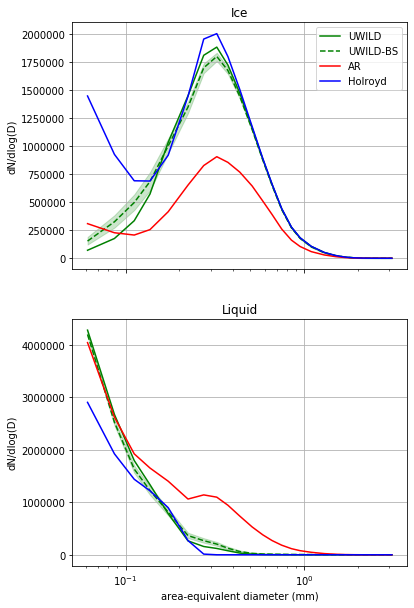

In [196]:
fig, [ax1, ax2] = plt.subplots(figsize=(6,10), nrows=2, sharex=True)
for ax in ax1, ax2:
    ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.grid('True')
    ax.set_ylabel('dN/dlog(D)')
#     ax.set_xlim([0.1, np.max(bins)])
#     ax.set_ylim([1e-6, 0.0015])
ax2.set_xlabel('area-equivalent diameter (mm)')
ax1.plot(bins, ice_ml_hist/log_width, label='UWILD', c='g')
ax1.plot(bins, ice_ml_hist_ml/log_width, label='UWILD-BS', c='g', ls='--')
ax1.fill_between(bins, ice_ml_hist_25/log_width, ice_ml_hist_75/log_width, color='g', alpha=0.2)
ax1.plot(bins, ice_ar_hist/log_width, label='AR', c='r')
ax1.plot(bins, ice_ho_hist/log_width, label='Holroyd', c='b')
ax2.plot(bins, liq_ml_hist/log_width, c='g')
ax2.plot(bins, liq_ml_hist_ml/log_width, label='UWILD-BS', c='g', ls='--')
ax2.fill_between(bins, liq_ml_hist_25/log_width, liq_ml_hist_75/log_width, color='g', alpha=0.2)
ax2.plot(bins, liq_ar_hist/log_width, c='r')
ax2.plot(bins, liq_ho_hist/log_width, c='b')
ax1.set_title('Ice')
ax2.set_title('Liquid')
ax1.legend()

In [171]:
ds.bin_edges

<xarray.DataArray 'bin_edges' (bin_edges: 28)>
array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.2  , 0.25 , 0.3  , 0.35 , 0.4  ,
       0.475, 0.55 , 0.625, 0.7  , 0.8  , 0.9  , 1.   , 1.2  , 1.4  , 1.6  ,
       1.8  , 2.   , 2.2  , 2.4  , 2.6  , 2.8  , 3.   , 3.2  ])
Coordinates:
  * bin_edges  (bin_edges) float64 0.05 0.075 0.1 0.125 0.15 ... 2.6 2.8 3.0 3.2
Attributes:
    units:    mm

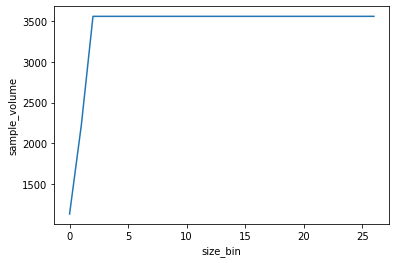

In [123]:
ds.sample_volume.mean(dim='time').plot()

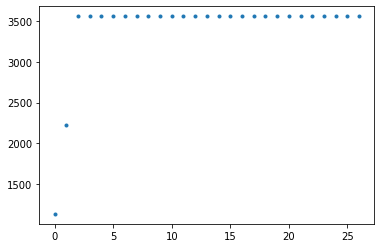

In [180]:
plt.plot(ds.sample_volume.mean(dim='time').values, '.')

In [181]:
ds.bin_edges

<xarray.DataArray 'bin_edges' (bin_edges: 28)>
array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.2  , 0.25 , 0.3  , 0.35 , 0.4  ,
       0.475, 0.55 , 0.625, 0.7  , 0.8  , 0.9  , 1.   , 1.2  , 1.4  , 1.6  ,
       1.8  , 2.   , 2.2  , 2.4  , 2.6  , 2.8  , 3.   , 3.2  ])
Coordinates:
  * bin_edges  (bin_edges) float64 0.05 0.075 0.1 0.125 0.15 ... 2.6 2.8 3.0 3.2
Attributes:
    units:    mm

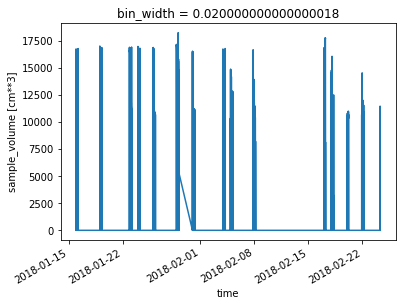

In [176]:
ds.sample_volume.isel(size_bin=-1).plot()

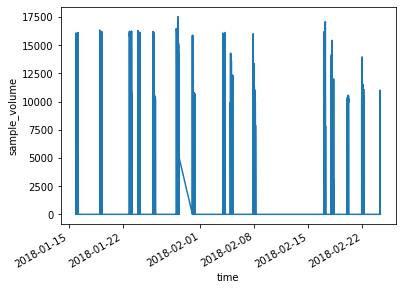

In [124]:
ds.sample_volume.mean(dim='size_bin').plot()

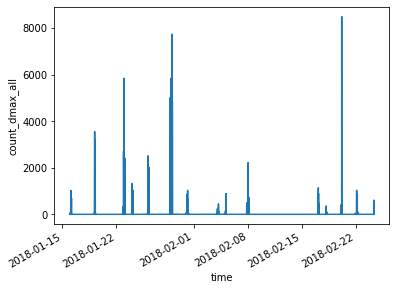

In [128]:
ds.count_dmax_all.sum(dim='size_bin').plot()

In [135]:
flt_string='rf04'
psd = xr.open_dataset(f'/home/disk/eos9/jkcm/Data/particle/psd/{flt_string}_psd.nc')
flt = xr.open_dataset(glob.glob('/home/disk/eos9/jfinlon/socrates/' + flt_string + '/*.PNI.nc')[0])


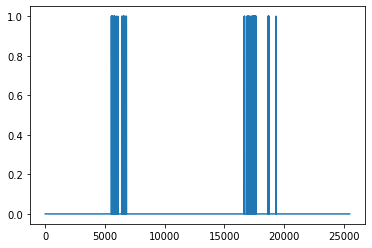

In [156]:
plt.plot(psd.lwc_ml>0.01)

In [167]:
thresh=0.01
x = np.logical_and(psd.lwc_ml.values>thresh, ~(flt.PLWCC.values>thresh))

In [169]:
plt.plot((psd.lwc_ml-psd.lwc_ml_mean))

AttributeError: 'Dataset' object has no attribute 'lwc_ml_mean'

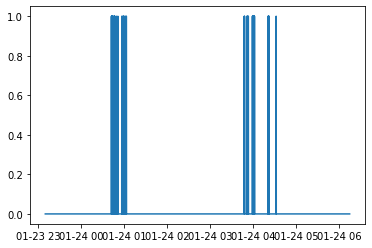

In [168]:
plt.plot(psd.time, x)

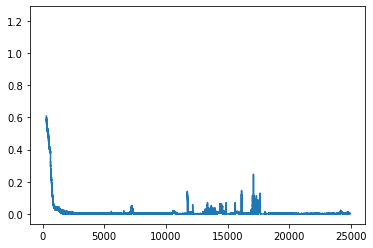

In [153]:
plt.plot(flt.PLWCC)

In [133]:
flt04 = xr.open_dataset('/home/disk/eos9/jfinlon/socrates/rf04/RF04.20180123.231000_061500.PNI.nc')

In [150]:
[(i,v.long_name) for i,v in flt.data_vars.items() if 'King' in v.long_name]

[('PLWCC', 'Corrected PMS-King Liquid Water Content')]

In [151]:
flt.PLWCC

<xarray.DataArray 'PLWCC' (Time: 25501)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2018-01-23T23:10:00 ... 2018-01-24T06:15:00
Attributes:
    units:                      gram/m3
    long_name:                  Corrected PMS-King Liquid Water Content
    standard_name:              atmosphere_cloud_liquid_water_content
    actual_range:               [0.        1.2291328]
    Category:                   Liquid Water
    DataQuality:                Good
    Dependencies:               5 PLWC TASX ATX PSXC CONCD_RWIO
    KING0_WIRE_TEMP:            150.0
    KING0_WIRE_DIAM:            0.001805
    KING0_WIRE_LEN:             0.021
    KING0_TAU_NUSSELT:          120.0
    KING_CLOUD_CONC_THRESHOLD:  1.0